IMPORTING LIBRARIES

###Steps to connect to kaggle

In [1]:
!pip install kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "*****" # username from the json file
os.environ['KAGGLE_KEY'] = "*****" # key from the json file

###Download train.csv and test.csv

In [3]:
!kaggle competitions download -c Kannada-MNIST

  0% 0.00/818k [00:00<?, ?B/s]
100% 818k/818k [00:00<00:00, 53.9MB/s]
 52% 5.00M/9.71M [00:00<00:00, 20.7MB/s]
100% 9.71M/9.71M [00:00<00:00, 32.2MB/s]
  0% 0.00/33.1k [00:00<?, ?B/s]
100% 33.1k/33.1k [00:00<00:00, 29.2MB/s]
  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 62.0MB/s]


In [8]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


###Importing libraries

In [4]:
import tensorflow as tf
import pandas as pd # for pandas data frame operations
import numpy as np # to work on numerical arrays
import seaborn as sns # seabonrn for visualization
import matplotlib.pyplot as plt # plots for visualization
import matplotlib.image as mpimg # to load image data
from sklearn.model_selection import train_test_split # to split train.csv data for cross validation
from sklearn.metrics import confusion_matrix # to construct confusion matrix
import itertools # has iterator functions for efficient looping
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # to construct in CNN
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D # Operations on CNN
from keras.optimizers import RMSprop # RMSProp optimizer
from keras.preprocessing.image import ImageDataGenerator # Image generator class
from keras.callbacks import ReduceLROnPlateau # Reduce learning rate callback function

Using TensorFlow backend.


###Setting environment for visulaization

In [0]:
%matplotlib inline
sns.set()

###Loading the data set

In [48]:
# Load the data (images stored as pixel values)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test.columns

Index(['id', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

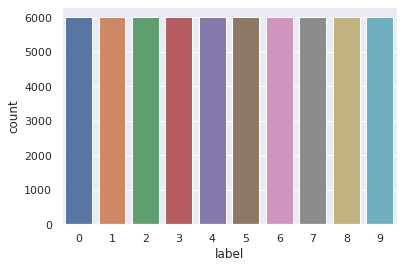

In [21]:
Y = train["label"] # target of train.csv data
X = train.drop(labels = ["label"],axis = 1) # Drop 'label' column from train.csv data
testX = test.drop(labels = ["id"],axis = 1) # Drop 'id' column from test.csv data
g = sns.countplot(Y) # display the distribution of digits in train.csv data
Y.value_counts().sort_values() # count the distribution of digits in train.csv data

In [0]:
del train # delete train dataframe to free some space 

###Preprocessing

In [23]:
#Check for null and missing values in train.csv data
X.isnull().any().describe() # the result shows there is no null values

count       784
unique        1
top       False
freq        784
dtype: object

In [24]:
#Check for null and missing values in test.csv data
testX.isnull().any().describe() # the result shows there is no null values

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
X = X / 255.0 # Normalize train.csv data
testX = testX / 255.0 # Normalize test.csv the data

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X = X.values.reshape(-1,28,28,1)
testX = testX.values.reshape(-1,28,28,1)

In [27]:
X.shape #reshaped from "42000 X 784" to "42000 X 28 X 28 X 1"

(60000, 28, 28, 1)

In [47]:
testX.shape

(5000, 28, 28, 1)

In [0]:
Y = to_categorical(Y, num_classes = 10) # one hot encoding (example: 2 -> [0,0,1,0,0,0,0,0,0,0])

In [29]:
Y # display the encoded target column

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, shuffle=True) # Split the train and the validation set for cross validation

In [31]:
# dimensions of the cross validation data
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(12000, 10)


###Display sample images from numpy array

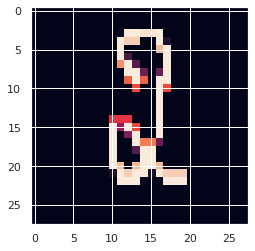

In [32]:
g = plt.imshow(X_train[0][:,:,0]) # first image

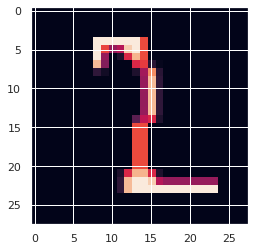

In [33]:
g = plt.imshow(X_train[1][:,:,0]) # second image

#Constructing the Convolutional Neural Network (CNN)
#### [Conv2D(relu) -> Conv2D(relu) -> MaxPool2D -> Dropout] -> [Conv2D(relu) -> Conv2D(relu) -> MaxPool2D -> Dropout] ->
####-> Flatten -> Dense -> Dropout -> Out

In [34]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu',
                 input_shape = (28,28,1))) # input 2D convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) # 2D max pooling
model.add(Dropout(0.25)) # applies dropout to prevent overfitting

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) # Flattens without affecting the size
model.add(Dense(256, activation = "relu")) # dense layer of size 256 units
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax")) # dense layer of size 10 to output the digit value






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) # RMSprop optimizer divides the gradient by root mean square
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"]) # Compile the model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            factor=0.3, 
                                            verbose=1, 
                                            min_lr=0.00001) # reduces learning rate if the learning is stagnant

In [0]:
# Generate batches of tensor image data with real-time data augmentation
# The data will be looped over (in batches).
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # zoom image
        width_shift_range=0.1,  # shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # shift images vertically (fraction of total height)
        horizontal_flip=False,  # flip images horizontally
        vertical_flip=False)  # flip images vertically
datagen.fit(X_train) # apply datagen augmentation to train.csv data

In [37]:
# Fit the model
epochs = 30
batch_size = 96
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30





 - 373s - loss: 0.2949 - acc: 0.9071 - val_loss: 0.0468 - val_acc: 0.9886
Epoch 2/30
 - 378s - loss: 0.1132 - acc: 0.9696 - val_loss: 0.0281 - val_acc: 0.9927
Epoch 3/30
 - 376s - loss: 0.0914 - acc: 0.9765 - val_loss: 0.0386 - val_acc: 0.9911
Epoch 4/30
 - 376s - loss: 0.0814 - acc: 0.9790 - val_loss: 0.0307 - val_acc: 0.9942
Epoch 5/30
 - 376s - loss: 0.0784 - acc: 0.9806 - val_loss: 0.0324 - val_acc: 0.9938
Epoch 6/30
 - 374s - loss: 0.0785 - acc: 0.9806 - val_loss: 0.0217 - val_acc: 0.9947
Epoch 7/30
 - 384s - loss: 0.0743 - acc: 0.9816 - val_loss: 0.0275 - val_acc: 0.9944
Epoch 8/30
 - 381s - loss: 0.0740 - acc: 0.9824 - val_loss: 0.0227 - val_acc: 0.9934
Epoch 9/30
 - 377s - loss: 0.0737 - acc: 0.9829 - val_loss: 0.0272 - val_acc: 0.9944

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 10/30
 - 366s - loss: 0.0484 - acc: 0.9872 - v

In [0]:
#tf.saved_model.save(model, "/")

###Visualizing the model **loss** and **accuracy**

In [42]:
# list all data in history
print(history.history.keys())
#history.history['loss']

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


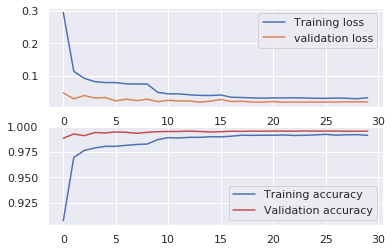

In [43]:
fig, ax = plt.subplots(2,1) # aligning two plots horizontally
ax[0].plot(history.history['loss'], label="Training loss") 
ax[0].plot(history.history['val_loss'],label="validation loss")
legend = ax[0].legend(loc='best')

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best')

###Making predictions on test.csv data

In [0]:
results = model.predict(testX) # predicting test.csv data
results = np.argmax(results,axis = 1) # select the index with maximum probability
results = pd.Series(results,name="label")

In [50]:
print(len(test['id']))
testX.shape # no. of rows in test.csv data

5000


(5000, 28, 28, 1)

In [51]:
# creating submission file
#submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1) 
submission = pd.concat([test['id'],results],axis = 1) 
submission.to_csv("kannada_mnist_using_cnn.csv",index=False)
print('csv file ready for submission')

csv file ready for submission
